In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skimage import io
from skimage.transform import resize

In [146]:
from tensorflow.keras import tfds

ImportError: cannot import name 'tfds' from 'tensorflow.keras' (C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\lib\site-packages\tensorflow\keras\__init__.py)

In [135]:
# labels_mode = 'int' by default, 'categorical' for one-hot encoding

train = tf.keras.preprocessing.image_dataset_from_directory(r"C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\Thesis\Dataset\Pics_20_5\Train", image_size = (64,60),
                                                                 color_mode = 'grayscale', seed = 41, shuffle = True, batch_size = 16, label_mode = 'int')
val = tf.keras.preprocessing.image_dataset_from_directory(r"C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\Thesis\Dataset\Pics_20_5\Val", image_size = (64,60),
                                                                 color_mode = 'grayscale', seed = 41, shuffle = True, batch_size = 16, label_mode = 'int')

test = tf.keras.preprocessing.image_dataset_from_directory(r"C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\Thesis\Dataset\Pics_20_5\Test", image_size = (60,64),
                                                                 color_mode = 'grayscale', seed = 1, shuffle = True, batch_size = 16, label_mode = 'int')

Found 338 files belonging to 2 classes.
Found 56 files belonging to 2 classes.
Found 42 files belonging to 2 classes.


In [4]:
data_dir = r"C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\Thesis\Dataset\Pics_20_5\Train"

# Define the target image size
target_size = (64, 60)

# Load the image data and labels
X = []
y = []
class_names = os.listdir(data_dir)
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_dir):
        img = io.imread(os.path.join(class_dir, filename))
        img = resize(img, target_size)
        X.append(img)
        y.append(i)

# Convert the data and labels to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Reshape the data into a flat vector for use with the random forest classifier
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [6]:
X_train_flat.shape

(5972, 3840)

In [159]:
initializer = tf.keras.initializers.GlorotUniform(seed = 41)

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))
model.add(Conv2D(32, kernel_size = (5, 3), padding = 'same', strides = (2, 1),#, 
            input_shape=(64, 60, 1), kernel_initializer = initializer))

model.add(LeakyReLU(alpha = 0.001))
model.add(MaxPooling2D(pool_size = (2,1)))
model.add(Conv2D(32, kernel_size = (5, 3), padding = 'same', strides = (2, 1), kernel_initializer = initializer))
model.add(LeakyReLU(alpha = 0.001))
model.add(MaxPooling2D(pool_size = (2,1)))

# model.add(BatchNormalization())


model.add(Conv2D(32, kernel_size = (5, 3), padding = 'same'))#tf.keras.layers.LeakyReLU(alpha=0.1)))
model.add(LeakyReLU(0.001))
model.add(MaxPooling2D(pool_size = (2,1)))
# model.add(BatchNormalization())
# # model.add(Dropout(0.5))

# model.add(Conv2D(128, kernel_size = (5, 3), padding = 'same'))#tf.keras.layers.LeakyReLU(alpha=0.1)))
# model.add(LeakyReLU())
# model.add(MaxPooling2D(pool_size = (2,1)))
# model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(6, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation= 'softmax', kernel_initializer = initializer))#'softmax')) #sigmoid for binary

# reduce_lr = ReduceLROnPlateau(monitor='_loss', factor=0.2,
#                               patience=5, min_lr=0.001)

# use "sparse_categorical_crossentropy" if labels are integers
# use "categorical_crossentropy" if labels are encoded using "one hot encoding"

model.compile(optimizer='adam',
              loss= 'sparse_categorical_crossentropy',#'categorical_crossentropy', 
              metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.75, 
                                            min_lr=0.0000001)

callbacks = [learning_rate_reduction, # tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')]

# datagen = ImageDataGenerator(rotation_range=20,
#                              width_shift_range=0.1,
#                              height_shift_range=0.1,
#                              shear_range=0.2,
#                              zoom_range=0.2,
#                              horizontal_flip=True)

# def augment(image, label):
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_brightness(image, max_delta=0.1)
#     image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
#     return image, label

# train_ds = train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
# train_ds = train_ds.shuffle(buffer_size=10000)
# train_ds = train_ds.batch(128)
# train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

# model.fit(train, 
#           epochs=10, batch_size=512)

In [160]:
history = model.fit(train,
                    callbacks = callbacks,
                    epochs=300,
                    validation_data=val)

Epoch 1/300
22/22 [==============================] - 2s 50ms/step - loss: 0.6948 - accuracy: 0.5844 - val_loss: 0.6926 - val_accuracy: 0.6071
Epoch 2/300
22/22 [==============================] - 1s 46ms/step - loss: 0.6897 - accuracy: 0.5480 - val_loss: 0.6881 - val_accuracy: 0.6071
Epoch 3/300
22/22 [==============================] - 1s 36ms/step - loss: 0.6922 - accuracy: 0.5546 - val_loss: 0.6795 - val_accuracy: 0.6071

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
Epoch 4/300
22/22 [==============================] - 1s 35ms/step - loss: 0.6896 - accuracy: 0.5638 - val_loss: 0.6829 - val_accuracy: 0.6071
Epoch 5/300
22/22 [==============================] - 1s 35ms/step - loss: 0.6770 - accuracy: 0.5840 - val_loss: 0.6836 - val_accuracy: 0.6071

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005625000048894435.
Epoch 6/300
22/22 [==============================] - 1s 36ms/step - loss: 0.6789 - accuracy: 0.5706 - val_loss: 0.6786 - val_acc

KeyboardInterrupt: 

In [153]:
test_ds = test.map(lambda x, y: (tf.divide(x, 255), y))

model.predict(test)

ValueError: in user code:

    C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\lib\site-packages\tensorflow\python\keras\engine\sequential.py:375 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\lib\site-packages\tensorflow\python\keras\engine\functional.py:424 call
        return self._run_internal_graph(
    C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\lib\site-packages\tensorflow\python\keras\engine\functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_66 is incompatible with the layer: expected axis -1 of input shape to have value 7680 but received input with shape (None, 8192)


In [92]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(60,64,1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [127]:
model1 = Sequential()
model1.add(Conv2D(8, (5, 3), activation='relu', input_shape=(64, 60, 1), strides = (2,1)))
model1.add(MaxPooling2D((2, 2)))
# model1.add(Conv2D(32, (3, 5), activation='relu'))
# model1.add(MaxPooling2D((2, 2)))
# model1.add(Conv2D(32, (3, 5), activation='relu'))

model1.add(Flatten())
model1.add(Dropout(0.5))
model1.add(Dense(8, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(2, activation = 'softmax'))

model1.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 30, 58, 8)         128       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 15, 29, 8)         0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 3480)              0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 3480)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 8)                 27848     
_________________________________________________________________
dropout_52 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_55 (Dense)             (None, 2)               

In [129]:
model1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# history = model.fit(train_images, train_labels, epochs=10, 
#                     validation_data=(test_images, test_labels))

history1 = model1.fit(train,
                    callbacks = callbacks,
                    epochs=25,
                    validation_data=val, 
                    validation_steps=1)

Epoch 1/25
22/22 [==============================] - 1s 18ms/step - loss: 1.6601 - accuracy: 0.5382 - val_loss: 0.7197 - val_accuracy: 0.1875
Epoch 2/25
22/22 [==============================] - 0s 11ms/step - loss: 0.6826 - accuracy: 0.5512 - val_loss: 0.6817 - val_accuracy: 0.3750
Epoch 3/25
22/22 [==============================] - 0s 10ms/step - loss: 1.2063 - accuracy: 0.4635 - val_loss: 0.6894 - val_accuracy: 0.5625
Epoch 4/25
22/22 [==============================] - 0s 10ms/step - loss: 1.1235 - accuracy: 0.5268 - val_loss: 0.7176 - val_accuracy: 0.5000
Epoch 5/25
22/22 [==============================] - 0s 11ms/step - loss: 1.6044 - accuracy: 0.5100 - val_loss: 0.6914 - val_accuracy: 0.3750

Epoch 00005: ReduceLROnPlateau reducing learning rate to 7.499999810534064e-05.
Epoch 6/25
22/22 [==============================] - 0s 12ms/step - loss: 1.1266 - accuracy: 0.4829 - val_loss: 0.6853 - val_accuracy: 0.5625
Epoch 7/25
22/22 [==============================] - 0s 11ms/step - loss: 

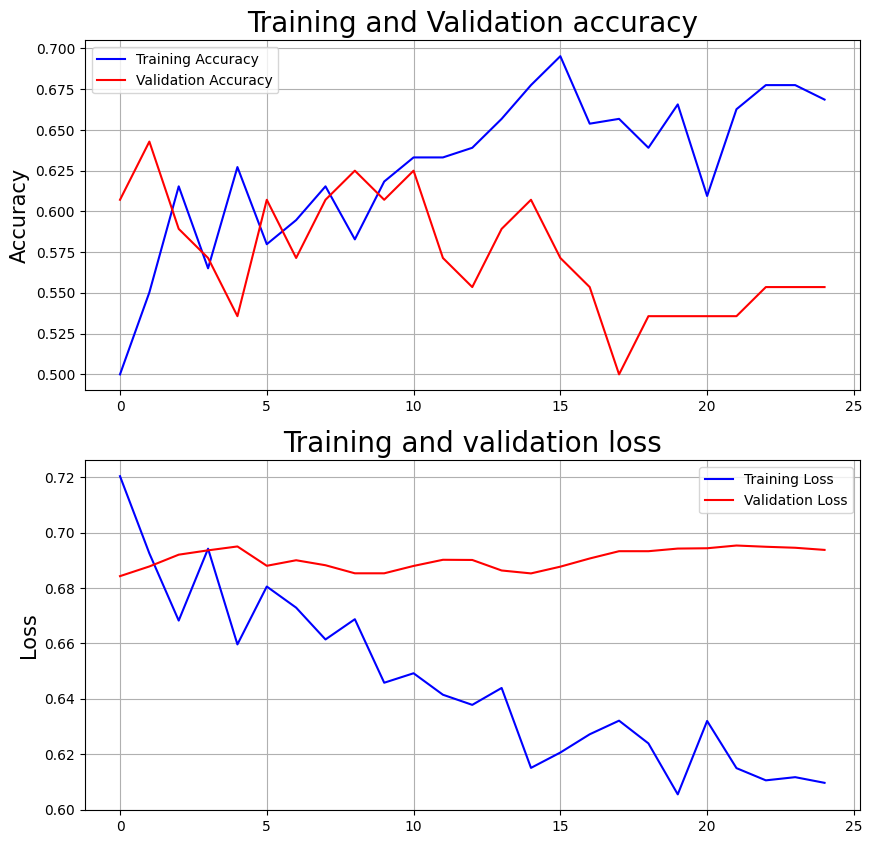

In [148]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(10,10),edgecolor='Black') 
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

ax1.plot(accuracy, label='Training Accuracy', color='Blue')
ax1.plot(val_accuracy, label='Validation Accuracy', color='Red')
ax1.set_title("Training and Validation accuracy", fontsize=20)
ax1.set_ylabel("Accuracy", fontsize=15)
ax1.legend()
ax1.grid('True')

ax2.plot(loss, label='Training Loss', color='Blue')
ax2.plot(val_loss, label='Validation Loss', color='Red')
ax2.set_title("Training and validation loss", fontsize=20)
ax2.set_ylabel("Loss", fontsize=15)
ax2.legend()
ax2.grid('True')

plt.show()

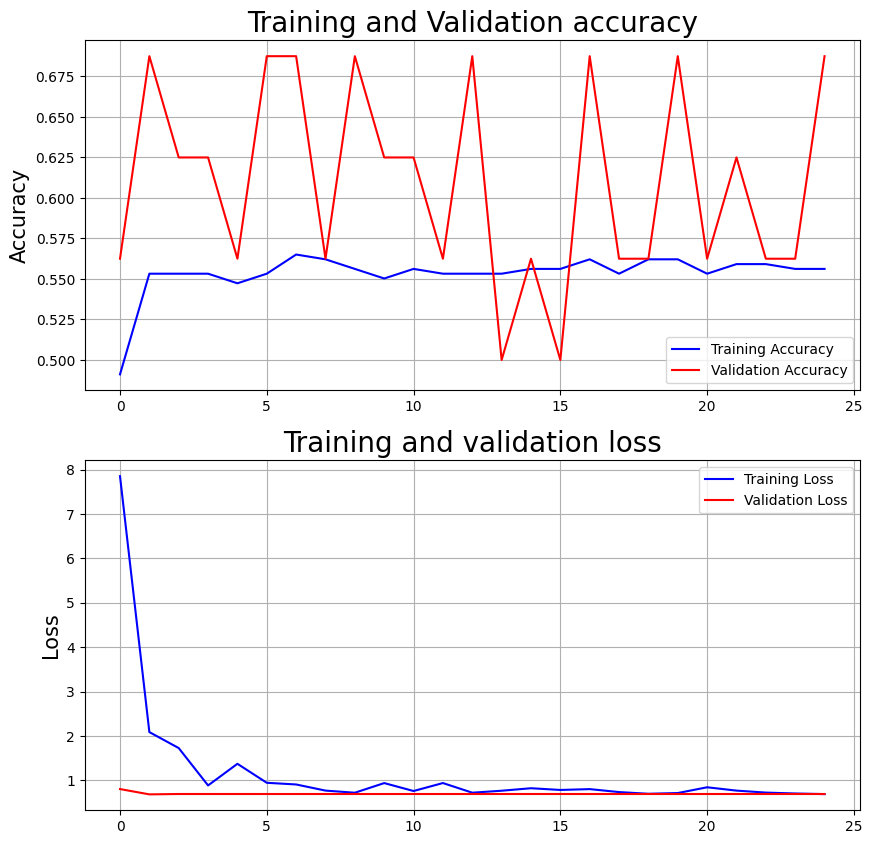

In [125]:
accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

fig = plt.figure(figsize=(10,10),edgecolor='Black') 
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

ax1.plot(accuracy, label='Training Accuracy', color='Blue')
ax1.plot(val_accuracy, label='Validation Accuracy', color='Red')
ax1.set_title("Training and Validation accuracy", fontsize=20)
ax1.set_ylabel("Accuracy", fontsize=15)
ax1.legend()
ax1.grid('True')

ax2.plot(loss, label='Training Loss', color='Blue')
ax2.plot(val_loss, label='Validation Loss', color='Red')
ax2.set_title("Training and validation loss", fontsize=20)
ax2.set_ylabel("Loss", fontsize=15)
ax2.legend()
ax2.grid('True')

plt.show()

In [32]:
labelsas = list(train.map(lambda x, y: y))